## Direct Digital Synthesis (DDS)

This example shows how to perform direct digital synthesis.

In [1]:
import math
import numpy as np

def sine(x):
    return np.sin(2 * math.pi * x)

x = np.linspace(0., 1., num=256, endpoint=False)

In [2]:
import magma as m
m.set_mantle_target('ice40')

In [3]:
import mantle

def DefineDDS(n):
    class _DDS(m.Circuit):
        name = f'DDS{n}'
        IO = ['I', m.In(m.UInt(n)), "O", m.Out(m.UInt(n))] + m.ClockInterface()
        @classmethod
        def definition(io):
            reg = mantle.Register(n)
            m.wire(reg(m.uint(reg.O) + io.I), io.O)
    return _DDS

def DDS(n):
    return DefineDDS(n)()

import lattice ice40
import lattice mantle40


In [4]:
from loam.boards.icestick import IceStick

icestick = IceStick()
icestick.Clock.on()
for i in range(8):
    icestick.J1[i].input().on()
    icestick.J3[i].output().on()

In [5]:
main = icestick.main()

dds = DDS(16)

wavetable = 128 + 127 * sine(x)
wavetable = [int(x) for x in wavetable]

rom = mantle.Memory(height=256, width=16, rom=list(wavetable), readonly=True)

phase = m.concat(m.bits(32, 8), m.bits(0,8))
addr = dds( phase )
O = rom( addr[8:] ) 
m.wire( 1, rom.RE )
m.wire( O[0:8], main.J3 )

m.EndCircuit()

Compile and build.

In [6]:
m.compile('build/dds', main)

In [7]:
%%bash
cd build
cat sin.pcf
yosys -q -p 'synth_ice40 -top main -blif dds.blif' dds.v
arachne-pnr -q -d 1k -o dds.txt -p dds.pcf dds.blif 
icepack dds.txt dds.bin
iceprog dds.bin

set_io J3[7] 44
set_io J3[6] 45
set_io J3[5] 47
set_io J3[4] 48
set_io J3[3] 56
set_io J3[2] 60
set_io J3[1] 61
set_io J3[0] 62
set_io CLKIN 21


init..
cdone: high
reset..
cdone: low
flash ID: 0x20 0xBA 0x16 0x10 0x00 0x00 0x23 0x64 0x34 0x65 0x03 0x00 0x71 0x00 0x26 0x27 0x12 0x16 0xD3 0xE4
file size: 32220
erase 64kB sector at 0x000000..
programming..
reading..
VERIFY OK
cdone: high
Bye.


We can wire up the GPIO pins to a logic analyzer to verify that our circuit produces the correct sine waveform.

![](images/dds.png)

We can also use Saleae's [export data](https://support.saleae.com/hc/en-us/articles/115005986806-Saving-Loading-and-Exporting-Data) feature to output a [csv file](data/dds-capture.csv). We'll load this data into Python and plot the results.

In [8]:
import csv
import magma as m
with open("data/dds-capture.csv") as sine_capture_csv:
    csv_reader = csv.reader(sine_capture_csv)
    next(csv_reader, None)  # skip the headers
    rows = [row for row in csv_reader]
timestamps = [float(row[0]) for row in rows]
values = [m.bitutils.seq2int(tuple(int(x) for x in row[1:])) for row in rows]

**TODO**: Why do we have this little bit of jitter? Logic analyzer is running at 25 MS/s, 3.3+ Volts for 1s

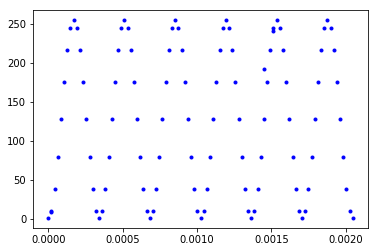

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(timestamps[:100], values[:100], "b.")